# Donald Trump's tweets sentiment analysis and correlation with approval ratings

## Imports and API initialization

In [2]:
%load_ext lab_black

In [3]:
import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='husl', font_scale=1.1, rc={"figure.figsize": [12, 8]})
import numpy as np
import datetime, json, logging, os, re
import preprocessor as pre
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk import word_tokenize
import spacy, en_core_web_sm
nlp = en_core_web_sm.load()
from collections import Counter

In [4]:
logging.basicConfig(filename='logfile.log', level=logging.DEBUG, 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

name = 'realDonaldTrump'

# dates range to collect tweets
start_date = datetime.datetime(2018, 12, 18, 0, 0, 0)
end_date = datetime.datetime(2019, 2, 19, 0, 0, 0)

consumer_key = '5NTdgEYyu0ikbduFxjPJconG0'
consumer_secret = 'RhoB2yyWl8L6mS3EmSEzCoMGlPsMX1z3XKQ0j2MXAagHwzU6yU'

oauth_token = '4227898119-lQpkWMTn4mUPxNX9kPpoHbWlRJsmjsAzPwUHyZ8'
oauth_token_secret = 'hp9Ga2IuDfPMGV2j56EfddLmaIrTP7BbgIWcurOXVaVY7'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(oauth_token, oauth_token_secret)

# the are rate limits for the frequency of API calls for twitter, 
# wait_on_rate_limit flag helps us not to worry about it while collecting the data
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [5]:
print(api.me().name)

Andrei


## Tweets collection

Now we collect the Trumps tweets from the specified date range. If already collected, read from file

In [6]:
def collect_tweets(tweets, file):
    """
    collect all tweets for the specified account and time range,
    save results to file
    
    """
    tweets_temp = api.user_timeline(
        screen_name=name,
        count=200,
        include_rts='false',
        tweet_mode='extended')
    for tweet in tweets_temp:
        if tweet.created_at < end_date and tweet.created_at > start_date:
            tweets.append(tweet._json)

    while (tweets_temp[-1].created_at > start_date):
        tweets_temp = api.user_timeline(
            screen_name=name,
            count=200,
            max_id=tweets_temp[-1].id,
            include_rts='false',
            tweet_mode='extended')
        for tweet in tweets_temp:
            if tweet.created_at < end_date and tweet.created_at > start_date:
                tweets.append(tweet._json)

    json.dump(tweets, file, indent=2)

In [7]:
%%time
if os.path.isfile('tweets.json') and not os.stat('tweets.json').st_size == 0:
    logging.info('File tweets.json already exists! Reading the file..')
    file = open('tweets.json', 'r', encoding='utf8')
    tweets = json.load(file)
    file.close()
else:
    logging.info('Creating tweets.json, collecting tweets..')
    file = open('tweets.json', 'w', encoding='utf8')
    tweets = []
    collect_tweets(tweets, file)
    file.close()

CPU times: user 21.8 ms, sys: 4.62 ms, total: 26.5 ms
Wall time: 24.8 ms


Create dataframe to store and process the data 

In [8]:
df = pd.DataFrame(data=[tweet['full_text'] for tweet in tweets], columns=['Text'])
df.head(10)

,Text
0,I ask every member of the Maduro regime: End t...
1,The people of Venezuela are standing for FREED...
2,We are here to proclaim that a new day is comi...
3,"Hope you are enjoying your President’s Day, ou..."
4,“This was an illegal coup attempt on the Presi...
5,Great analysis by @foxandfriends!
6,....There is a lot of explaining to do to the ...
7,"Wow, so many lies by now disgraced acting FBI ..."
8,“After two years and interviewing more than tw...
9,William Barr is arriving at a Justice Departme...


Let's see what attributes available for each tweet object

In [9]:
print('id:',tweets[0]['id'])
print('date:',tweets[0]['created_at'])
print('likes:',tweets[0]['favorite_count'])
print('retweets:',tweets[0]['retweet_count'])
print(tweets[0]['entities'])

id: 1097625026801688579
date: Mon Feb 18 22:32:53 +0000 2019
likes: 149000
retweets: 41579
{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}


Now let's add interesting attributes to the dataframe

In [10]:
df['len'] = np.array([len(tweet['full_text']) for tweet in tweets])
df['id'] = np.array([tweet['id'] for tweet in tweets])
df['Date'] = np.array([tweet['created_at'] for tweet in tweets])
df['Likes'] = np.array([tweet['favorite_count'] for tweet in tweets])
df['RTs'] = np.array([tweet['retweet_count'] for tweet in tweets])
df.head()

,Text,len,id,Date,Likes,RTs
0,I ask every member of the Maduro regime: End t...,268,1097625026801688579,Mon Feb 18 22:32:53 +0000 2019,149000,41579
1,The people of Venezuela are standing for FREED...,130,1097624329154674689,Mon Feb 18 22:30:07 +0000 2019,111651,31140
2,We are here to proclaim that a new day is comi...,217,1097623506580357120,Mon Feb 18 22:26:51 +0000 2019,96212,30255
3,"Hope you are enjoying your President’s Day, ou...",89,1097592331405066242,Mon Feb 18 20:22:58 +0000 2019,155374,24288
4,“This was an illegal coup attempt on the Presi...,110,1097488256848007173,Mon Feb 18 13:29:25 +0000 2019,115008,30164


In [11]:
min(df.Date), max(df.Date)

('Fri Dec 21 03:13:54 +0000 2018', 'Wed Jan 30 21:58:38 +0000 2019')

In [12]:
df.shape

(533, 6)

## Natural Language Processing


### Data preprocessing

Now lets do some preprocessing to prepare it for the entities extraction

In [13]:
# remove @user mentions, # hashtag symbol, URLs, emoji etc.
# check the package documentation for info
# pre.set_options(pre.OPT.URL, pre.OPT.EMOJI, pre.OPT.MENTION, pre.OPT.RESERVED, pre.OPT.SMILEY, pre.OPT.NUMBER)
text_processed = df['Text'].apply(lambda s: pre.clean(s))

# removing all non alpha-numeric symbols
text_processed = text_processed.apply(lambda s: re.sub(r'[^A-Za-z0-9 ]', '', s))

# removing stop words
text_processed = text_processed.apply(lambda s: ' '.join(word for word in s.split() if word not in stop_words))

In [14]:
print('Before:\n' + df['Text'][9] + '\n\nAfter:\n' + text_processed[9])

Before:
William Barr is arriving at a Justice Department that desperately needs an infusion of credibility, writes @KimStrassel https://t.co/naY9XOxb12 via @WSJ

After:
William Barr arriving Justice Department desperately needs infusion credibility writes via


## Entities extraction
Now after cleaning the data we can extract entities using SpaCy and NLTK and add it to the dataframe

To see the transcription for the entities codes check the SpaCy documentation

In [15]:
def get_entities(text):
    """
    Extract counts for each entity found in input text
    """
    return dict(Counter([s.label_ for s in nlp(text).ents]))

In [16]:
%%time
entities = text_processed.apply(lambda s: get_entities(s))
entities = entities.apply(pd.Series)

CPU times: user 8.45 s, sys: 53.8 ms, total: 8.5 s
Wall time: 4.28 s


In [17]:
df = pd.concat([df, entities], axis=1)
df.head()

,Text,len,id,Date,Likes,RTs,PERSON,ORG,CARDINAL,GPE,...,NORP,PRODUCT,MONEY,ORDINAL,TIME,LAW,EVENT,WORK_OF_ART,FAC,QUANTITY
0,I ask every member of the Maduro regime: End t...,268,1097625026801688579,Mon Feb 18 22:32:53 +0000 2019,149000,41579,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The people of Venezuela are standing for FREED...,130,1097624329154674689,Mon Feb 18 22:30:07 +0000 2019,111651,31140,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,We are here to proclaim that a new day is comi...,217,1097623506580357120,Mon Feb 18 22:26:51 +0000 2019,96212,30255,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Hope you are enjoying your President’s Day, ou...",89,1097592331405066242,Mon Feb 18 20:22:58 +0000 2019,155374,24288,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,“This was an illegal coup attempt on the Presi...,110,1097488256848007173,Mon Feb 18 13:29:25 +0000 2019,115008,30164,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Collection of replies/comments

Now as we collected all Trump's tweets for the desired period, we can loop through them and actually collect people's reactions by getting the replies to these tweets

In [ ]:
def collect_replies(tweets, file):
    """
    collect replies for all the collected tweets of the specified account,
    query gets 100 replies per page, 10 pages give 1000 replies in total,
    then compares with desired parameters,
    finally saves results to file.
    
    """
    for tweet in tweets:
        for page in tweepy.Cursor(
            api.search,
            # filter tweets by replies to @name and exclude retweets
            q='to:' + name + ' -filter:retweets',
            since_id=tweet['id'],
            count=100,
            # specifiy what type of search results you would prefer to receive. 
            # default is "mixed"
            result_type='mixed',
            tweet_mode='extended').pages(10):
            for status in page:
                if hasattr(status, 'in_reply_to_status_id_str'):
                    logging.info('Found a reply to the tweet with id=',
                                 status.in_reply_to_status_id_str,
                                 'text=' + status.text)
                    replies.append(status._json)
                    logging.info('Reply added to the list. Continue...')
    
    json.dump(replies, file, indent=2)

In [ ]:
%%time
if os.path.isfile('replies.json') and not os.stat('replies.json').st_size == 0:
    logging.info('File replies.json already exists! Reading the file..')
    file = open('replies.json', 'r', encoding='utf8')
    replies = json.load(file)
    file.close()
else:
    logging.info('Creating replies.json, collecting tweets..')
    file = open('replies.json', 'w', encoding='utf8')
    replies = []
    collect_replies(tweets, file)
    file.close()

## Sentiment Analysis

Now we'll calculate the sentiment intensity for each of Trump's tweets using VADER which is especially tailored to work with social media texts

In [18]:
analyzer = SentimentIntensityAnalyzer()

sentiment_intensity = df['Text'].apply(lambda s: analyzer.polarity_scores(s))
sentiment_intensity = sentiment_intensity.apply(pd.Series)
df = pd.concat([df, sentiment_intensity], axis=1)

df.loc[df.neu > .5, 'Sentiment'] = 'neutral'
df.loc[df.neg > .5, 'Sentiment'] = 'negative'
df.loc[df.pos > .5, 'Sentiment'] = 'positive'

df.head()

,Text,len,id,Date,Likes,RTs,PERSON,ORG,CARDINAL,GPE,...,LAW,EVENT,WORK_OF_ART,FAC,QUANTITY,neg,neu,pos,compound,Sentiment
0,I ask every member of the Maduro regime: End t...,268,1097625026801688579,Mon Feb 18 22:32:53 +0000 2019,149000,41579,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.206,0.692,0.103,-0.7261,neutral
1,The people of Venezuela are standing for FREED...,130,1097624329154674689,Mon Feb 18 22:30:07 +0000 2019,111651,31140,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,0.000,0.714,0.286,0.8412,neutral
2,We are here to proclaim that a new day is comi...,217,1097623506580357120,Mon Feb 18 22:26:51 +0000 2019,96212,30255,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,0.000,0.898,0.102,0.5267,neutral
3,"Hope you are enjoying your President’s Day, ou...",89,1097592331405066242,Mon Feb 18 20:22:58 +0000 2019,155374,24288,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000,0.516,0.484,0.8553,neutral
4,“This was an illegal coup attempt on the Presi...,110,1097488256848007173,Mon Feb 18 13:29:25 +0000 2019,115008,30164,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.147,0.612,0.241,0.3164,neutral


We marked the tweets as neutral/negative/positive based on the calculated sentiment intensity (where it is > 0.5 accordingly). Now lets take a look at the count and distribution of positive/negative tweets based on these marks.

In [24]:
Counter(df['Sentiment'])

Counter({'neutral': 508,
         'positive': 16,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         'negative': 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1})

(0, 40)

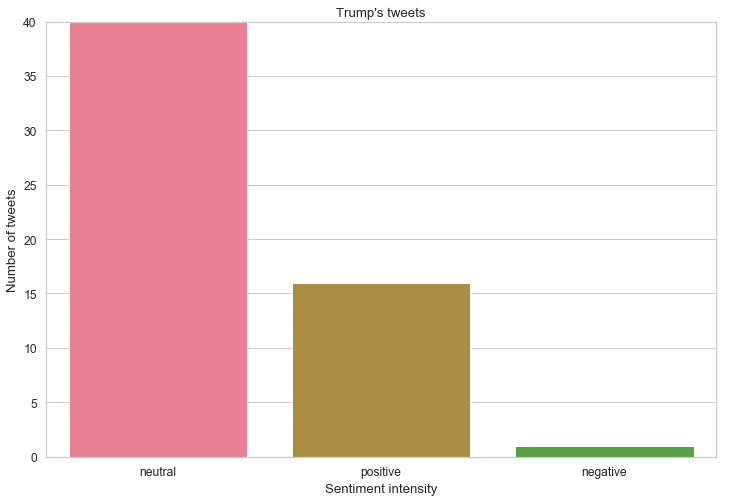

In [30]:
sns.countplot(df['Sentiment'])
plt.xlabel('Sentiment intensity')
plt.ylabel('Number of tweets')
plt.title('Trump\'s tweets')
plt.ylim(0, 40)

As we can see there are far more neutral tweets than any other, number of positive tweets is around 15 out of total 533, and only a few negative tweets for the specified period of time.

However there is the so-called compound component of the sentiment intensity which shows summary of the approximation. Let's also take a look at the distrivution of this component.

Text(0.5, 1.0, "Trump's tweets distribution")

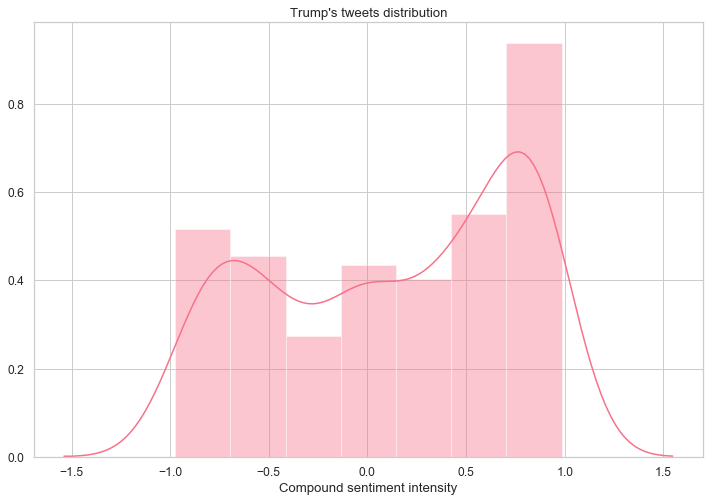

In [31]:
sns.distplot(df['compound'])
plt.xlabel('Compound sentiment intensity')
plt.title('Trump\'s tweets distribution')